# Introdução

Esse Notebook será responsável pelo preprocessamento dos dados contidos em ./data/raw para formatos compatíveis e otimizados para o treinamento de cada modelo
As definições dos parâmetros do treinamento aos quais os modelos deverão solucionar já foram definidas no notebook "Coleta de Dados"

Modelos a serem Criados:

1. Modelo Linear: MLP sem funções de ativação, composta apenas de somas lineares
2. MLP: rede neural - efetivamente identica ao modelo linear, no entanto, apresenta função de ativação ao final do somatório de funções lineares
3. LSTM: Um modelo de rede neural recorrente, com capacidade de diferenciação de informação de curto e longo prazo
4. TFT: Modelo baseado em LLMs desenvolvido pela microsoft - servirá como um comparativo mais moderno


## Dependências

In [1]:
import os
import shutil
import importlib

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# ==============================================
# TORCH INSTALL (GPU-safe)
# ==============================================
try:
    import torch
    print(f"torch={torch.__version__} | cuda={torch.cuda.is_available()}")
except Exception:
    print("⚙️ Installing PyTorch with correct CUDA runtime...")
    has_gpu = shutil.which("nvidia-smi") is not None

    # Clean any broken torch/CUDA stack
    os.system("pip uninstall -y torch torchvision torchaudio nvidia-*")

    if has_gpu:
        # CUDA 12.1 build — safest baseline for current PyTorch
        os.system(
            "pip install torch==2.5.1+cu121 torchvision==0.20.1+cu121 torchaudio==2.5.1+cu121 "
            "--index-url https://download.pytorch.org/whl/cu121 --quiet"
        )
    else:
        os.system(
            "pip install torch torchvision torchaudio "
            "--index-url https://download.pytorch.org/whl/cpu --quiet"
        )

    import torch
    print(f"✅ torch={torch.__version__} | cuda={torch.cuda.is_available()}")

# ==============================================
# TFT & PIPELINE LIBS
# ==============================================
try:
    import pytorch_lightning
    import pytorch_forecasting
except ImportError:
    print("📦 Installing PyTorch Lightning + Forecasting...")
    os.system("pip install pytorch-lightning pytorch-forecasting --quiet")

# ==============================================
# PARQUET / I/O LIBS
# ==============================================
try:
    import pyarrow as pa
    print(f"PyArrow disponível: {pa.__version__}")
except ImportError:
    print("📦 Installing PyArrow >= 18...")
    os.system("pip install --upgrade 'pyarrow>=18' --quiet")
    importlib.invalidate_caches()
    import pyarrow as pa
    print(f"PyArrow instalado: {pa.__version__}")

try:
    import fastparquet
    print("fastparquet disponível (opcional)")
except ImportError:
    pass

# ==============================================
# BASE LIBRARIES
# ==============================================
base_libs = [
    "numpy",
    "python-dotenv",
    "pandas",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "tensorflow[and-cuda]",
    "keras",
    "lxml",
    "pytz",
    "optuna",
]

for lib in base_libs:
    try:
        __import__(lib.split("[")[0])
    except ImportError:
        print(f"📦 Installing {lib}...")
        os.system(f"pip install --quiet {lib}")

print("✅ All dependencies ready")


torch=2.5.1+cu121 | cuda=True


/home/victor-bertini/Documentos/tcc_2025/TCC-2025/tfc_venv/lib/python3.12/site-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


PyArrow disponível: 22.0.0
📦 Installing python-dotenv...


📦 Installing scikit-learn...


✅ All dependencies ready


## VARIÁVEIS NECESSÁRIAS

In [2]:
# Imports centralizados
import os, json, time, gc, concurrent.futures, datetime
from typing import Any, Dict, List, Optional, Tuple
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping as TFEarlyStopping, ReduceLROnPlateau as TFReduceLROnPlateau

# PyTorch / Lightning / TFT
import torch
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping as LGEarlyStopping, LearningRateMonitor as LGLearningRateMonitor, ModelCheckpoint as LGModelCheckpoint
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Parquet
import pyarrow as pa
import pyarrow.parquet as pq

# Local preprocessor classes
from preprocessor import LinearPreprocessor, LSTMPreprocessor, TFTPreprocessor

# Silenciando Warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=Warning)  # last resort
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)



# ==============================================
# GPU CONFIGURATION
# ==============================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    mixed_precision.set_global_policy('mixed_float16')
    print(f"✅ GPU detected ({gpus[0].name}) - using mixed precision.")
else:
    print("⚠️ No GPU detected, running on CPU.")

# Carregar variáveis de ambiente do .env
load_dotenv()
# ---------------- CONFIG ---------------- #
COUNTRY_DOMAINS = {
    "FR": {"domain": "10YFR-RTE------C"},
    "ES": {"domain": "10YES-REE------0"},
    "PT": {"domain": "10YPT-REN------W"}
}

DATA_ITEMS = [
    {'key': 'load_total', 'documentType': 'A65', 'processType': 'A16', 'domainParam': 'outBiddingZone_Domain', 'parser': 'load'},
    {'key': 'market_prices', 'documentType': 'A44', 'processType': 'A07', 'domainParamIn': 'in_Domain', 'domainParamOut': 'out_Domain', 'parser': 'price'}
]

ENTSOE_TOKEN = os.environ.get("ENTSOE_SECURITY_TOKEN")
BASE_URL = "https://web-api.tp.entsoe.eu/api"
MAX_WORKERS = 100
RAW_DIR = os.path.join("data", "raw")
PARQUET_COMPRESSION = "zstd"
os.makedirs(RAW_DIR, exist_ok=True)
EPOCHS = 200

# ==============================================
# DICIONÁRIO DE Treinamento
# ==============================================
treinamento = {
    "name": "treinamento",
    "data_dir": "data/treinamento",
    "feats": ["country", "datetime", "quantity_MW"],
    "tgts": ["quantity_MW"],
    "vals": ["quantity_MW"],
    "lag": 10 * 24,
    "lead": 3 * 24,
    "seq_len": 10 * 24,
    "countries": list(COUNTRY_DOMAINS),
    "noise": False,
    "train": True
}

# Gerador do dataset CV
cv = {
    "name": "CV",
    "data_dir": "data/CV",
    "feats": ["country", "datetime", "quantity_MW"],
    "tgts": ["quantity_MW"],
    "vals": ["quantity_MW"],
    "lag": 10 * 24,
    "lead": 3 * 24,
    "seq_len": 10 * 24,
    "countries": list(COUNTRY_DOMAINS),
    "noise": False,
    "size": 0.2
}

perguntas = [
    {
        "name": "N1A",
        "data_dir": "data/N1A",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 3 * 24,
        "countries": ["ES"],
        "noise": False
    },
    {
        "name": "N1B",
        "data_dir": "data/N1B",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 7 * 24,
        "countries": ["ES"],
        "noise": False
    },
    {
        "name": "N1C",
        "data_dir": "data/N1C",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 10 * 24,
        "countries": ["ES"],
        "noise": False
    },
    {
        "name": "N2A",
        "data_dir": "data/N2A",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 3 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": False
    },
    {
        "name": "N2B",
        "data_dir": "data/N2B",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 7 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": False
    },
    {
        "name": "N2C",
        "data_dir": "data/N2C",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 10 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": False
    },
        {
        "name": "N3A",
        "data_dir": "data/N3A",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 3 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": True
    },
    {
        "name": "N3B",
        "data_dir": "data/N3B",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 7 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": True
    },
    {
        "name": "N3C",
        "data_dir": "data/N3C",
        "feats": ["country", "datetime", "quantity_MW"],
        "tgts": ["quantity_MW"],
        "vals": ["quantity_MW"],
        "lag": 10 * 24,
        "lead": 3 * 24,
        "seq_len": 10 * 24,
        "countries": COUNTRY_DOMAINS.keys(),
        "noise": True
    }
]



✅ GPU detected (/physical_device:GPU:0) - using mixed precision.


# Capítulo 1: Préprocessamento de dados

Etapa de contrução da pipelines de pre-processamento de dados


## Preprocessamento do Modelo Linear

Esse modelo deve será contruido a partir de lags e leads passados como parâmetros na função, resultando na contrução de novas colunas lead lag, assim gerando uma flat matrix 2D que será usada no modelo linear

Observação importante: lag e lead são inteiros e representam o máximo de passos; o pipeline expande para intervalos 1..N automaticamente. Por exemplo, lag=96 gera features com defasagens de 1 a 96; lead=96 gera alvos de 1 a 96.

Os arquivos do modelo serão salvos em Parquet, já que o modelo linear será construído usando TensorFlow (carregado via Parquet→NumPy→tf.data)

No caso o Preprocessador do modelo linear será igual ao pré-processador do MLP 

## Preprocessamento do Modelo LSTM

O preprocessador do LSTM deve ser capaz de gerar tensores de dimensão 3, no seguinte formato (n_batch, seq_len, features) e (n_batch, seq_len, features)  para alimentação do modelo e validação das métricas do modelo

Os arquivos do modelo serão salvos em Parquet (colunas X e Y como listas fixas), e carregados via Parquet→NumPy→tf.data

## Preprocessamento do Modelo TFT (PyTorch)

O preprocessador do LSTM deve ser capaz de gerar tensores de dimensão 3, no seguinte formato (n_batch, seq_len, features) e (n_batch, seq_len, features)  para alimentação do modelo e validação das métricas do modelo

Os artefatos de dados serão salvos em Parquet (Keras e TFT).

# Capítulo 2 — Construção dos Modelos

A seguir, definimos construtores simples e eficientes para cada modelo (Linear, LSTM, TFT e TimesFM),
prontos para uso em rotinas de otimização de hiperparâmetros (por exemplo, Optuna). Cada construtor
recebe um dicionário de parâmetros (`params`) e retorna um modelo compilado.

## Construção do Modelo Linear/MLP

Objetivo: Criar um regressor simples (MLP), com capacidade de redução para um modelo apenas lienar - pela exclusão da camada de ativação - para prever `target_cols` a partir de `feature_cols`.

Contrato rápido:
- Entrada: vetor de tamanho `x_dim` (número de features)
- Saída: vetor de tamanho `y_dim` (número de targets)
- Parâmetros (exemplos): hidden_units, activation, dropout, lr, l2

In [3]:
# Linear/MLP model + loaders (Parquet only)
# (imports centralizados na célula 5)
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_linear_model(x_dim: int, y_dim: int, params: dict, linear: bool = False) -> keras.Model:
    """Builds either a pure linear or a simple MLP model for regression."""

    lr = params.get("lr", 1e-3)
    l2 = params.get("l2", 0.0)
    dropout = params.get("dropout", 0.0)
    hidden_units = params.get("hidden_units", [128, 64])
    activation = params.get("activation", "leaky_relu")

    inputs = keras.Input(shape=(x_dim,), name="features")

    if linear:
        x = inputs
    else:
        x = inputs
        for i, units in enumerate(hidden_units):
            x = layers.Dense(units, activation=activation,
                             kernel_regularizer=regularizers.l2(l2))(x)
            if dropout > 0:
                x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(y_dim, activation=None, name="targets")(x)

    model = keras.Model(inputs, outputs, name="linear_model" if linear else "mlp_model")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"]
    )
    return model


def build_mlp_model(x_dim: int, y_dim: int, params: Dict[str, Any]) -> keras.Model:

    # --- HYPERPARAMS ---
    hidden_units = params.get('hidden_units', [128, 64])  
    dropout = float(params.get('dropout', 0.0))            
    lr = float(params.get('lr', 1e-3))                     
    l2 = float(params.get('l2', 1e-6))                     
    activation = params.get('act', 'relu')

    # --- MODEL ---
    inputs = keras.Input(shape=(x_dim,), name='features')
    x = inputs  # 🚫 no LayerNormalization()

    # hidden layers
    for i, units in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=activation,
            kernel_initializer='he_normal',
            kernel_regularizer=keras.regularizers.l2(l2),
            name=f"dense_{i}"
        )(x)

        if dropout > 0:
            x = layers.Dropout(dropout, name=f"drop_{i}")(x)

    # output layer
    outputs = layers.Dense(y_dim, activation=None, name='targets')(x)

    model = keras.Model(inputs, outputs, name='mlp_model')

    # --- OPTIMIZER ---
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )

    return model


## Construção do Modelo LSTM

Objetivo: um regressor denso simples (MLP) para prever `target_cols` a partir de `feature_cols`.

Contrato rápido:
- Entrada: vetor de tamanho `x_dim` (número de features)
- Saída: vetor de tamanho `y_dim` (número de targets)
- Parâmetros (exemplos): hidden_units, activation, dropout, lr, l2

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


def build_lstm_model(
    seq_len=240,
    x_dim_num=12,
    y_dim=1,
    lead=72,
    num_countries=4,
    emb_dim=8,
    lstm_units_enc=128,
    lstm_units_dec=64,
    dense_units=256,
    dropout_cpu=0.15,
    lr=3e-3,
):
    """
    Proper causal LSTM forecaster.
    - Compatible with CuDNN GPU kernels.
    - Removes temporal averaging.
    - Adds encoder/decoder structure.
    - Named explicitly "lstm" to avoid generic 'functional' model saves.
    """

    # --- Detect if GPU (CuDNN) is available ---
    gpu_available = len(tf.config.list_physical_devices("GPU")) > 0
    dropout = 0.0 if gpu_available else dropout_cpu

    # === Inputs ===
    num_in = keras.Input(shape=(None, x_dim_num), name="num_feats")
    country_in = keras.Input(shape=(1,), dtype="int32", name="country_id")

    # === Country embedding ===
    emb = layers.Embedding(num_countries, emb_dim, name="country_emb")(country_in)
    emb = layers.Reshape((1, emb_dim))(emb)

    # === Dynamic embedding repetition ===
    def repeat_to_seq_len(inputs):
        emb, feats = inputs
        seq_len = tf.shape(feats)[1]
        return tf.tile(emb, [1, seq_len, 1])  # (B, seq_len, emb_dim)

    emb_rep = layers.Lambda(repeat_to_seq_len, name="emb_repeat_dyn")([emb, num_in])

    # === Feature concat ===
    x = layers.Concatenate(axis=-1, name="concat_feats")([num_in, emb_rep])

    # === Encoder LSTM ===
    x = layers.LSTM(
        lstm_units_enc,
        return_sequences=True,
        dropout=dropout,
        recurrent_dropout=dropout,
        name="encoder_lstm",
    )(x)

    # === Decoder LSTM ===
    x = layers.LSTM(
        lstm_units_dec,
        return_sequences=False,
        dropout=dropout,
        recurrent_dropout=dropout,
        name="decoder_lstm",
    )(x)

    # === Normalization + Dense projection ===
    x = layers.LayerNormalization(name="layer_norm")(x)
    x = layers.Dense(dense_units, activation="gelu", name="dense_proj")(x)
    x = layers.Dropout(dropout, name="dropout_dense")(x)

    # === Forecast output ===
    x = layers.Dense(lead * y_dim, activation=None, name="dense_output")(x)
    out = layers.Reshape((lead, y_dim), name="reshape_output")(x)

    # === Model ===
    model = keras.Model(
        inputs=[num_in, country_in],
        outputs=out,
        name="lstm"  # ✅ explicit model name
    )

    # === Compile ===
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
        loss="mse",
        metrics=["mae"],
    )
    return model


## Construção do Modelo TFT (Temporal Fusion Transformer)

**Objetivo:** prever `target_cols` a partir de `feature_cols` utilizando a implementação oficial `keras_tft`,  
que integra **seleção de variáveis dinâmicas**, **blocos LSTM**, **atenção temporal multi-cabeças** e **gating residual** em um único modelo interpretable.

**Contrato rápido:**
- **Entrada:** `tf.data.Dataset` com tensores no formato `(batch, seq_len, x_dim)`  
- **Saída:** tensor contínuo de tamanho `y_dim` *(ou `dec_len × y_dim` para horizontes múltiplos)*

**Parâmetros (exemplos):**  
`hidden_size` (tamanho interno das camadas GRN) · `lstm_layers` · `num_heads` (atenção) · `dropout` · `learning_rate` · `output_size` · `seq_len`

**Componentes internos (`keras_tft`):**  
Variable Selection Network → LSTM Encoder/Decoder → Multi-Head Temporal Attention → Gated Residual Network → Camada de projeção final

**Compatibilidade:**  
Totalmente compatível com o pipeline atual em Parquet do LSTM, recebendo o mesmo formato de dados  
(`(batch, seq_len, features)`), permitindo substituição direta do modelo sem alterar o pré-processamento.



In [5]:
# TFT model builder (imports centralizados na célula 5)

def build_tft_model(
    params: Dict[str, Any]
):
    """
    Constrói um Temporal Fusion Transformer (TFT) com parâmetros configuráveis.

    Args:
        x_dim: número de features de entrada
        y_dim: número de targets
        seq_len: tamanho da sequência temporal
        params: dicionário de hiperparâmetros (hidden_size, dropout, lstm_layers, etc.)
        max_encoder_length: tamanho da janela passada (encoder)
        max_prediction_length: tamanho do horizonte de previsão (decoder)
    """

    hidden_size = int(params.get("hidden_size", 64))
    dropout = float(params.get("dropout", 0.1))
    lstm_layers = int(params.get("lstm_layers", 1))
    attention_head_size = int(params.get("num_heads", 4))
    lr = float(params.get("lr", 1e-3))

    model = TemporalFusionTransformer.from_dataset(
        params["dataset"],  # dataset preparado via TimeSeriesDataSet
        learning_rate=lr,
        hidden_size=hidden_size,
        dropout=dropout,
        lstm_layers=lstm_layers,
        attention_head_size=attention_head_size,
        loss=QuantileLoss([0.5]),
        log_interval=10,
        log_val_interval=1
    )

    return model

# Capítulo 3 - Contrução da Pipelines de dados dos modelos

A função de pipeline organiza o fluxo de dados para, de forma mais concisa e organizada, treinar o modelo, sendo capaz de mostrar a progressão das perdas a medida que as épocas de treinamento passam - Esse display esté disponível no notebook "Resultados"

O resultado da pipeline é um gráfico com a evolução de todas as métricas e o salvamento do modelo treinado dentro da pasta ./modelo/{Nome_Problema}/{Nome_Modelo}

Assim podendo ser facilmente reutilizado futuramente para um notebook comparativo

In [6]:
# Utilitário para salvar modelos Keras (imports centralizados na célula 5)

def save_model(model, path: str, format: str | None = None, include_optimizer: bool = True) -> str:
    """
    Salva um modelo Keras em formato padronizado.

    Regras:
    - Se `path` terminar com .keras ou .h5, salva exatamente nesse arquivo.
    - Se `format == 'savedmodel'`, salva no diretório indicado (SavedModel).
    - Caso contrário, adiciona sufixo .keras a `path` (arquivo único Keras v3).

    Retorna o caminho final salvo (arquivo ou diretório) e grava um meta.json ao lado.
    """
    # Inferência de formato por extensão
    ext = None
    lower = path.lower()
    if lower.endswith(".keras"):
        ext = "keras"
    elif lower.endswith(".h5") or lower.endswith(".hdf5"):
        ext = "h5"

    # Normalização de destino
    if format == "savedmodel":
        # Diretório SavedModel
        save_dir = path
        os.makedirs(save_dir, exist_ok=True)
        model.save(save_dir, include_optimizer=include_optimizer)
        meta_path = os.path.join(save_dir, "model.meta.json")
        final_path = save_dir
    else:
        if ext is None:
            # Força arquivo .keras por padrão
            path = f"{path}.keras"
            ext = "keras"
        # Cria diretório pai
        parent = os.path.dirname(path) or "."
        os.makedirs(parent, exist_ok=True)
        # Salva arquivo único
        model.save(path, include_optimizer=include_optimizer)
        meta_path = f"{path}.meta.json"
        final_path = path

    # Meta básico ao lado do artefato
    try:
        meta = {
            "saved_at": datetime.datetime.utcnow().isoformat() + "Z",
            "keras_version": getattr(model, "keras_version", None),
            "model_name": getattr(model, "name", None),
            "trainable_params": int(getattr(model, "count_params", lambda: 0)()),
            "format": "savedmodel" if format == "savedmodel" else ext,
        }
        with open(meta_path, "w", encoding="utf-8") as f:
            json.dump(meta, f, ensure_ascii=False, indent=2)
    except Exception as e:
        print(f"[WARN] Falha ao escrever meta.json: {e}")

    print(f"[💾] Modelo salvo em: {final_path}")
    return final_path

## Pipeline dos Modelos Lineares

Pipeline de preprocessamento e de treinamento

In [7]:
# Pipelines dos Modelos Lineares (imports centralizados na célula 5)

def linear_preproccess_pipeline(
    preproc: LinearPreprocessor,
    destino_dir: str,
    save_instance: bool = True,
    seq_len=None,
    masked_value=None,
    train: bool = False,
    size: Optional[float] = 1.0,
    noise: bool = False
) -> Tuple[LinearPreprocessor, Dict[str, Any]]:
    """
    Pipeline completa de pré-processamento (Parquet only) e treinamento de 3 modelos
    usando apenas a classe unificada Preprocessor.

    Retorna o preprocessor (para reutilizar escalers/mapeamentos) e um dicionário
    com resultados/resumos do treinamento dos modelos lineares/MLP.
    """

    print("🔄 Carregando dados brutos ...")
    preproc.load_data(size=size, noise=noise)

    print("🔤 Encoding de colunas categóricas/temporais ...")
    preproc.encode(encode_cols='datetime', encode_method='time_cycle', train=train)
    preproc.encode(encode_cols='country', encode_method='label', train=train)

    print("✂️ Split train/val/test ...")
    preproc.split_train_val_test(train_size=0.8, val_size=0.1, test_size=0.1, time_col='datetime')

    print("📐 Normalização ...")
    preproc.normalize_splits(normalization_method='standard', train=train)

    print("🔳 Construindo matrizes planas para Linear/MLP ...")
    preproc.build_flat_matrices_splits(
        dropna=True,
        group_cols=['country'],
        time_col='datetime',
        seq_len=seq_len,
        mask_value=masked_value
    )

    print("💾 Salvando parquets LINEAR/MLP ...")
    preproc.save_linear_splits_parquet(basename='linear_dataset')

    if save_instance and train:
       path = os.path.join(destino_dir, "preprocessor")
       preproc.save_instance(path, name="linear_preproc.pkl")

    print("📦 Dataset Parquet carregado para treinamento.")

    return preproc

def linear_train_pipeline(
    problem_name: str,
    data_dir: str,
    batch_size: int = 128,
    configs: Dict[str, Dict[str, Any]] = None
):
    # ----------------------------
    # Parquet datasets
    # ----------------------------
    dataset_train, meta_tr = LinearPreprocessor.load_linear_parquet_dataset(data_dir=data_dir, split='train', batch_size=batch_size, shuffle=True)
    dataset_val, meta_va = LinearPreprocessor.load_linear_parquet_dataset(data_dir=data_dir, split='val', batch_size=batch_size, shuffle=False)


    x_dim = int(meta_tr["x_dim"])
    y_dim = int(meta_tr["y_dim"])
    print("📦 Dataset Parquet carregado para treinamento.")

    histories = {}
    models = {}

    early_stopping = TFEarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=0)
    reduce_lr = TFReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=0)

    # ----------------------------
    # Treinamento de cada modelo
    # ----------------------------
    for name, params in configs.items():
        print(f"\n🚀 Treinando modelo {name}...")

        linear_bool = params.get("linear")
        if linear_bool:
            model = build_linear_model(x_dim=x_dim, y_dim=y_dim, params=params, linear=linear_bool)
        else:
            model = build_mlp_model(x_dim=x_dim, y_dim=y_dim, params=params)
        

        hist = model.fit(
            dataset_train,
            validation_data=dataset_val,
            epochs=EPOCHS,
            callbacks=[early_stopping, reduce_lr],
            verbose=2
)

        histories[name] = hist
        models[name] = model
        print(f"✅ {name} concluído - Val Loss: {min(hist.history['val_loss']):.6f}")

    # ----------------------------
    # Salvando modelos
    # ----------------------------
    for name, model in models.items():
        # Salvando modelo no path /modelos/{nome do problema}/{nome do modelo}
        save_model(model, path = f"./modelos/{problem_name}/{name}")
    
    
    return models, histories

## Pipelines dos modelos LSTM
Implementação e uso dos preprocessors e treinadores LSTM para séries temporais (janelas seq_len e lead).

In [8]:
import tensorflow as tf
import numpy as np

def sanity_check_prefetch(ds: tf.data.Dataset, n: int = 3, n_vals: int = 5):
    """
    Quick sanity check for tf.data.Dataset (prefetched/batched).
    Prints shape, dtype, and sample values for a few batches.

    Args:
        ds : tf.data.Dataset — dataset to inspect
        n  : int — number of batches to preview
        n_vals : int — number of feature values to display (first & last)
    """
    print("🔍 Dataset sanity check...")
    for i, (x, y) in enumerate(ds.take(n)):
        print(f"\n[Batch {i+1}] ===============================")

        # --- X INFO ---
        if isinstance(x, dict):
            print("X: (dict)")
            for k, v in x.items():
                arr = v.numpy() if tf.is_tensor(v) else np.array(v)
                print(f" • {k:<20} shape={arr.shape} dtype={arr.dtype}")
                flat = arr.flatten()
                if flat.size > 0:
                    head = np.array2string(flat[:n_vals], precision=4, separator=", ")
                    tail = np.array2string(flat[-n_vals:], precision=4, separator=", ")
                    print(f"   first: {head}")
                    print(f"   last : {tail}")
        else:
            arr = x.numpy() if tf.is_tensor(x) else np.array(x)
            print(f"X shape={arr.shape} dtype={arr.dtype}")
            flat = arr.flatten()
            if flat.size > 0:
                head = np.array2string(flat[:n_vals], precision=4, separator=", ")
                tail = np.array2string(flat[-n_vals:], precision=4, separator=", ")
                print(f"  first: {head}")
                print(f"  last : {tail}")

        # --- Y INFO ---
        arr_y = y.numpy() if tf.is_tensor(y) else np.array(y)
        print(f"Y shape={arr_y.shape} dtype={arr_y.dtype}")
        flat_y = arr_y.flatten()
        if flat_y.size > 0:
            head_y = np.array2string(flat_y[:n_vals], precision=4, separator=", ")
            tail_y = np.array2string(flat_y[-n_vals:], precision=4, separator=", ")
            print(f"  y first: {head_y}")
            print(f"  y last : {tail_y}")

        if i + 1 >= n:
            break
    print("\n✅ Done.")


In [9]:
# Pipelines dos modelos LSTM (imports centralizados na célula 5)

def lstm_preproccess_pipeline(
    preproc: LSTMPreprocessor,
    destino_dir: str,
    save_instance: bool = True,
    train: bool = False,
    size: Optional[float] = 1.0,
    noise: bool = False
) -> Tuple[LSTMPreprocessor, Dict[str, Any]]:
    

    print("🔄 Carregando dados brutos ...")
    preproc.load_data(size=size, noise=noise)
    
    print("🔤 Encoding ...")
    preproc.encode(encode_cols="datetime", encode_method="time_cycle", train=train)
    preproc.encode(encode_cols="country", encode_method="label", train=train)

    print("✂️ Split train/val/test ...")
    preproc.split_train_val_test(train_size=0.6, val_size=0.2, test_size=0.2, time_col="datetime")
    
    print("📐 Normalização ...")
    preproc.normalize_splits(normalization_method="standard", train=train)

    print("🔳 Construindo matrizes sequenciais para LSTM ...")
    preproc.build_sequence_matrix_splits(
        group_cols=['country'],
        time_col="datetime"
    )

    print("💾 Salvando parquets LSTM ...")
    preproc.save_splits_parquet(basename="lstm_dataset")

    if save_instance and train:
        path = os.path.join(destino_dir, "preprocessor")
        preproc.save_instance(path, name="lstm_preproc.pkl")

    print("📦 Dataset LSTM Parquet carregado para treinamento.")
    return preproc

def lstm_train_pipeline(
    problem_name: str,
    data_dir: str,
    seq_len: int,
    batch_size: int = 128,
    configs: Dict[str, Dict[str, Any]] = None
) -> Dict[str, keras.Model]:
    # ----------------------------
    # Parquet datasets
    # ----------------------------
    dataset_train, meta_tr = LSTMPreprocessor.load_lstm_parquet_dataset(data_dir=data_dir, split="train", batch_size=batch_size, shuffle=False)
    dataset_val, meta_va = LSTMPreprocessor.load_lstm_parquet_dataset(data_dir=data_dir, split="val", batch_size=batch_size, shuffle=False)

    x_dim = int(meta_tr["x_dim"]) ; y_dim = int(meta_tr["y_dim"]) ; seq_len_m = int(meta_tr["seq_len"]) ; lead_m = int(meta_tr["lead"]) 
    if seq_len and seq_len != seq_len_m:
        print(f"[WARN] seq_len fornecido ({seq_len}) difere do meta ({seq_len_m}). Usando meta.")
    print("📦 Dataset Parquet carregado para treinamento.")

    histories = {}
    models = {}

    early_stopping = TFEarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=0)
    reduce_lr = TFReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-6, verbose=0)

    for name, params in configs.items():
        print(f"\n🚀 Treinando modelo {name}...")
        model = build_lstm_model(seq_len=seq_len_m, x_dim_num=x_dim, y_dim=y_dim, lead=lead_m, num_countries=4, **params)
        tf.keras.backend.clear_session()
        gc.collect()
        hist = model.fit(
            dataset_train,
            validation_data=dataset_val,
            epochs=EPOCHS,
            callbacks=[early_stopping, reduce_lr],
            verbose=2,
        )

        histories[name] = hist
        models[name] = model

        print(f"✅ {name} concluído - Val Loss: {min(hist.history['val_loss']):.6f}")

    # ----------------------------
    # Salvando modelos
    # ----------------------------
    for name, model in models.items():
        save_model(model, path = f"./modelos/{problem_name}/{name}")
    
    return models, histories

## Pipelines dos modelos TFT
Pré-processamento em parquet e treino com PyTorch Forecasting (Temporal Fusion Transformer) via Lightning.

In [10]:
# Pipelines dos modelos TFT (imports centralizados na célula 5)
from lightning.pytorch import Trainer, seed_everything, Callback
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
import torch, os
from typing import Dict, Any, List


def tft_preproccess_pipeline(
    preproc: TFTPreprocessor,
    destino_dir: str,
    save_instance: bool = True,
    train: bool = False,
    size: Optional[float] = 1.0,
    noise: bool = False
) -> Tuple[TFTPreprocessor, Dict[str, Any]]:

    print("🔄 Carregando dados brutos ...")
    preproc.load_data(size=size, noise=noise)

    print("🔤 Encoding ...")
    preproc.encode(encode_cols='datetime', encode_method='time_cycle', train=train)
    preproc.encode(encode_cols='country', encode_method='label', train=train)

    print("✂️ Split train/val/test ...")
    preproc.split_train_val_test(train_size=0.8, val_size=0.1, test_size=0.1, time_col='datetime')

    print("📐 Normalização ...")
    preproc.normalize_splits(normalization_method='standard', train=train)


    print("🧱 Construindo parquets para TFT ...")
    preproc.build_tft_parquets(
        group_cols=['country'],
        time_col='datetime'
)

    if save_instance and train:
        path = os.path.join(destino_dir, "preprocessor")
        preproc.save_instance(path, name="tft_preproc.pkl")

    print("📦 Parquets TFT salvos. Carregando dataset ...")

    return preproc




from lightning.pytorch import Trainer, seed_everything, Callback
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import Logger
import torch, os
from typing import Dict, Any, List


# ----------------------------------------------------
# Minimal dummy logger (satisfies callbacks, no files)
# ----------------------------------------------------
class DummyLogger(Logger):
    def __init__(self):
        super().__init__()
        self._version = 0
    @property
    def name(self): return "dummy"
    @property
    def version(self): return self._version
    def log_metrics(self, metrics, step=None): pass
    def log_hyperparams(self, params): pass
    def experiment(self): return None


def tft_train_pipeline(
    problem_name: str,
    data_dir: str,
    feature_cols: List[str],
    target_cols: List[str],
    seq_len: int,
    lead: int,
    batch_size: int = 128,
    configs: Dict[str, Dict[str, Any]] = None,
):
    """
    Treina modelos TFT (Temporal Fusion Transformer) com PyTorch Lightning.
    Retorna (models, histories) — histories[name].history['loss'] / ['val_loss'] como em Keras.
    """

    # ----------------------------
    # 1. Carregar dados
    # ----------------------------
    preproc = TFTPreprocessor(
        data_dir=data_dir,
        model_name="tft_model",
        feature_cols=feature_cols,
        target_cols=target_cols,
        seq_len=seq_len,
        lead=lead,
        country_list=[],
    )

    df_train = preproc.load_tft_dataset("train", target_col=target_cols[0])
    df_val   = preproc.load_tft_dataset("val",   target_col=target_cols[0])

    train_loader = df_train.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_loader   = df_val.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    print(f"📦 Dados TFT — batches: train={len(train_loader)} | val={len(val_loader)}")

    models, histories = {}, {}
    seed_everything(42)
    accelerator = "gpu" if torch.cuda.is_available() else "cpu"

    # ----------------------------
    # 2. Custom loss collector
    # ----------------------------
    class LossHistoryCallback(Callback):
        def __init__(self):
            super().__init__()
            self.history = {"loss": [], "val_loss": []}

        def on_train_epoch_end(self, trainer, pl_module):
            metrics = trainer.callback_metrics
            if "train_loss" in metrics:
                self.history["loss"].append(float(metrics["train_loss"]))
            elif "loss" in metrics:
                self.history["loss"].append(float(metrics["loss"]))

        def on_validation_epoch_end(self, trainer, pl_module):
            metrics = trainer.callback_metrics
            if "val_loss" in metrics:
                self.history["val_loss"].append(float(metrics["val_loss"]))

    # ----------------------------
    # 3. Loop de presets
    # ----------------------------
    for name, params in (configs or {}).items():
        print(f"\n🚀 Treinando TFT preset: {name} [{accelerator}]")

        model = build_tft_model(params={**params, "dataset": df_train})

        save_dir = os.path.join("modelos", problem_name, "TFT", name)
        os.makedirs(save_dir, exist_ok=True)

        loss_collector = LossHistoryCallback()

        callbacks = [
            loss_collector,
            EarlyStopping(monitor="val_loss", patience=int(params.get("patience", 5)), mode="min"),
            LearningRateMonitor(logging_interval="epoch"),
            ModelCheckpoint(
                dirpath=save_dir,
                filename="best",
                monitor="val_loss",
                save_top_k=1,
                mode="min",
            ),
        ]

        # ✅ Use DummyLogger to satisfy LRMonitor
        trainer = Trainer(
            max_epochs=int(params.get("epochs", 50)),
            accelerator=accelerator,
            devices=1,
            callbacks=callbacks,
            default_root_dir=save_dir,
            log_every_n_steps=10,
            logger=DummyLogger(),   # <— in-memory, silent
            precision=32,
        )

        # ----------------------------
        # 4. Treinamento
        # ----------------------------
        trainer.fit(model, train_loader, val_loader)
        print(f"✅ {name} concluído — melhor checkpoint salvo em {save_dir}")

        # ----------------------------
        # 5. Histórico tipo Keras
        # ----------------------------
        class HistoryLike:
            def __init__(self, hist): self.history = hist

        history = HistoryLike(loss_collector.history)

        print(f"\n📊 Histórico ({name}) — últimas perdas:")
        print("train_loss:", history.history["loss"][-5:])
        print("val_loss:", history.history["val_loss"][-5:])

        models[name] = model
        histories[name] = history

    return models, histories


# Capítulo 4: Preprocessamento de dados

In [11]:
try:
    import optuna
except ImportError:
    optuna = None
    print("[WARN] Optuna não instalado. Instale com pip install optuna para habilitar HPO.")

full_configs = perguntas
full_configs.append(cv)  # lista de problemas adicionais  e dataset reduzido para CV (N1A.. etc.)

# =============================
# Preprocessamento base para treinamento (cfg 'treinamento')
# =============================
preprocess_collector = {}

def run_preprocessing(cfg: Dict[str, Any],
                      preproc_train_linear: Optional[LinearPreprocessor] = None,
                      preproc_train_lstm: Optional[LSTMPreprocessor] = None,
                      preproc_train_tft: Optional[TFTPreprocessor] = None):
    """Executa sequencialmente as três pipelines gerando datasets parquet.
    Retorna instâncias dos preprocessadores com splits salvos.
    """
    destino_dir = cfg["data_dir"]
    lag = cfg.get("lag", 24)
    lead = cfg.get("lead", 24)
    seq_len = cfg.get("seq_len", lag)

    preproc_lin = LinearPreprocessor(
        model_name="Linear",
        lag=lag,
        lead=lead,
        country_list=cfg["countries"],
        feature_cols=cfg["feats"],
        target_cols=cfg["tgts"],
        data_dir=destino_dir,
        num_cols=cfg.get("vals")
    )

    preproc_lstm = LSTMPreprocessor(
        model_name="LSTM",
        lag=seq_len,
        lead=lead,
        country_list=cfg["countries"],
        feature_cols=cfg["feats"],
        target_cols=cfg["tgts"],
        data_dir=destino_dir,
        num_cols=cfg.get("vals")
    )

    preproc_tft = TFTPreprocessor(
        model_name="TFT",
        seq_len=seq_len,
        lead=lead,
        country_list=cfg["countries"],
        feature_cols=cfg["feats"],
        target_cols=cfg["tgts"],
        data_dir=destino_dir,
    )
    # Ajusta num_cols se não fornecido explicitamente
    if not preproc_tft.num_cols and cfg.get("vals"):
        preproc_tft.num_cols = list(cfg["vals"])  # compatibilidade

    # Herdando encoders / normalizadores se fornecidos
    for src, dst in [
        (preproc_train_linear, preproc_lin),
        (preproc_train_lstm, preproc_lstm),
        (preproc_train_tft, preproc_tft),
    ]:
        if src:
            try:
                dst.encod_objects = src.encod_objects
                dst.norm_objects = src.norm_objects
            except Exception:
                pass

    print("==== PIPELINE LINEAR/MLP ====")
    preproc_lin = linear_preproccess_pipeline(
        preproc=preproc_lin,
        destino_dir=destino_dir,
        seq_len=seq_len,
        masked_value=0.0,
        save_instance=True,
        train=cfg.get("train", False),
        size=cfg.get("size", 1.0),
        noise=cfg.get("noise", False)
    )

    print("==== PIPELINE LSTM ====")
    preproc_lstm = lstm_preproccess_pipeline(
        preproc=preproc_lstm,
        destino_dir=destino_dir,
        save_instance=True,
        train=cfg.get("train", False),
        size=cfg.get("size", 1.0),
        noise=cfg.get("noise", False)
    )

    print("==== PIPELINE TFT ====")
    preproc_tft = tft_preproccess_pipeline(
        preproc=preproc_tft,
        destino_dir=destino_dir,
        save_instance=True,
        train=cfg.get("train", False),
        size=cfg.get("size", 1.0),
        noise=cfg.get("noise", False)
    )

    preprocess_collector[cfg["name"]] = {
        "linear": preproc_lin,
        "lstm": preproc_lstm,
        "tft": preproc_tft,
    }

    return preproc_lin, preproc_lstm, preproc_tft


## Processamento individual de dataset completo, para setting de parâmetros de encodding e decoding
train_preproc_linear, train_preproc_lstm, train_preproc_tft = run_preprocessing(treinamento)

## Paralelização da geração de dataset de Perguntas N1A -> N3C
max_workers = max(len(full_configs), 4)

print(f"🚀 Executando {len(full_configs)} tarefas em {max_workers} workers...")

results = [None] * len(full_configs)
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(run_preprocessing, 
        item,
        preproc_train_linear=train_preproc_linear,
        preproc_train_lstm=train_preproc_lstm,
        preproc_train_tft=train_preproc_tft): 
        idx for idx, item in enumerate(full_configs)}
    
    for i, future in enumerate(as_completed(futures)):
        idx = futures[future]
        try:
            results[idx] = future.result()
        except Exception as e:
            print(f"[ERROR] item {idx}: {e}")
            results[idx] = None
        if (i + 1) % max(1, len(full_configs)//10) == 0:
            print(f"  Progresso: {i+1}/{len(full_configs)}")

print("✅ Tarefa concluída.")

==== PIPELINE LINEAR/MLP ====
🔄 Carregando dados brutos ...
🔤 Encoding de colunas categóricas/temporais ...
✂️ Split train/val/test ...
[DIVIDIDO] train: 83,831 linhas
[DIVIDIDO] val: 10,478 linhas
[DIVIDIDO] test: 10,480 linhas
📐 Normalização ...
🔳 Construindo matrizes planas para Linear/MLP ...
💾 Salvando parquets LINEAR/MLP ...
[Linear:train] linhas=82,895  X=251  Y=73  escrevendo em chunks de 200,000…
[💾] Parquet salvo: data/treinamento/linear_dataset_train.parquet
[Linear:val] linhas=9,542  X=251  Y=73  escrevendo em chunks de 200,000…
[💾] Parquet salvo: data/treinamento/linear_dataset_val.parquet
[Linear:test] linhas=9,544  X=251  Y=73  escrevendo em chunks de 200,000…
[💾] Parquet salvo: data/treinamento/linear_dataset_test.parquet
✅ Instance saved at data/treinamento/preprocessor/linear_preproc.pkl
📦 Dataset Parquet carregado para treinamento.
==== PIPELINE LSTM ====
🔄 Carregando dados brutos ...
🔤 Encoding ...
✂️ Split train/val/test ...
[DIVIDIDO] train: 62,873 linhas
[DIVIDID

# Capítulo 5: Definição da estrutura dos modelos - Com otimização de hiperparm para o MLP, Linear, LSTM
Configuração dos parâmetros dos modelos

In [ ]:
# Configurações padrões dos modelos
gpu_devices = tf.config.list_physical_devices('GPU')
# Configurações dos modelos
configs_linear = {
    "linear": {
        "linear": True,
        "units": [128, 64],
        "dropout": 0.1,
        "lr": 5e-4,
        "l2": 1e-6,
        "act": "leaky_relu",
        "layer_norm": False,
        "mask_value": -0.0,
    }
}

configs_mlp = {
    "mlp": {
        "linear": False,
        "units": [128, 64],
        "dropout": 0.1,
        "lr": 5e-4,
        "l2": 1e-6,
        "act": "leaky_relu",
        "layer_norm": False,
        "mask_value": -0.0,
    }
}

configs_lstm = {
    "lstm": {
        "emb_dim": 8,
        "lstm_units": 128,
        "dense_units": 64,
        "dropout": 0 if gpu_devices else 0.15,
        "lr": 5e-4
    }
}




# ============================
# Optuna: otimização (Linear/MLP/LSTM)
# ============================
import os, json
from typing import Dict, Any
import optuna

def _ensure_dirs(*paths):
    for p in paths:
        os.makedirs(p, exist_ok=True)


# ============================
# LINEAR / MLP
# ============================
def _linear_objective(trial: "optuna.trial.Trial", data_dir: str, batch_size: int, model_kind: str = "linear") -> float:
    ds_train, meta_tr = LinearPreprocessor.load_linear_parquet_dataset(
        data_dir=data_dir, split='train', batch_size=batch_size, shuffle=True
    )
    ds_val, meta_va = LinearPreprocessor.load_linear_parquet_dataset(
        data_dir=data_dir, split='val', batch_size=batch_size, shuffle=False
    )
    x_dim, y_dim = int(meta_tr['x_dim']), int(meta_tr['y_dim'])

    # Search space
    units1 = trial.suggest_int("units1", 32, 256, step=32)
    units2 = trial.suggest_int("units2", 16, 256, step=16)
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5) if not gpu_devices else 0.0
    lr = trial.suggest_float("lr", 1e-5, 5e-3, log=True)
    l2 = trial.suggest_float("l2", 1e-7, 1e-3, log=True)
    act = trial.suggest_categorical("act", ["tanh", "leaky_relu"]) if model_kind != "linear" else "leaky_relu"
    layer_norm = trial.suggest_categorical("layer_norm", [False, True]) if model_kind != "linear" else False

    params = {
        "linear": (model_kind == "linear"),
        "units": [units1] + ([units2] if n_layers >= 2 else []),
        "dropout": dropout,
        "lr": lr,
        "l2": l2,
        "act": act,
        "layer_norm": layer_norm,
        "mask_value": -0.0,
    }

    model = (
        build_linear_model(x_dim=x_dim, y_dim=y_dim, params=params, linear=True)
        if model_kind == "linear"
        else build_mlp_model(x_dim=x_dim, y_dim=y_dim, params=params)
    )

    callbacks = [
        TFEarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=0),
        TFReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=0),
    ]

    history = model.fit(ds_train, validation_data=ds_val, epochs=30, verbose=0, callbacks=callbacks)
    val_loss = min(history.history.get("val_loss", [float("inf")]))
    trial.report(val_loss, step=1)
    if trial.should_prune():
        raise optuna.TrialPruned()
    return float(val_loss)


def optimize_linear_or_mlp(problem_name: str, data_dir: str, model_kind: str = "linear",
                           n_trials: int = 20, batch_size: int = 256) -> Dict[str, Any]:
    assert model_kind in ("linear", "mlp")
    study = optuna.create_study(
        direction="minimize",
        study_name=f"{problem_name}_{model_kind}_opt",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
    )
    study.optimize(lambda t: _linear_objective(t, data_dir, batch_size, model_kind), n_trials=n_trials)

    best = study.best_trial
    best_params = dict(best.params)
    units = [best_params.pop("units1"), best_params.pop("units2", None)]
    units = [u for u in units if u]
    best_params_recon = {
        "linear": (model_kind == "linear"),
        "units": units if units else [64],
        "dropout": best_params.get("dropout", 0.1),
        "lr": best_params.get("lr", 1e-3),
        "l2": best_params.get("l2", 1e-6),
        "act": best_params.get("act", "leaky_relu"),
        "layer_norm": best_params.get("layer_norm", False),
        "mask_value": -0.0,
    }
    out_dir = os.path.join("resultados", "hparams", problem_name)
    _ensure_dirs(out_dir)
    with open(os.path.join(out_dir, f"best_{model_kind}.json"), "w", encoding="utf-8") as f:
        json.dump(best_params_recon, f, indent=2, ensure_ascii=False)
    print(f"💾 Best {model_kind} params saved to {out_dir}")
    return best_params_recon


# ============================
# LSTM
# ============================
def _lstm_objective(trial: "optuna.trial.Trial", data_dir: str, batch_size: int) -> float:
    ds_train, meta_tr = LSTMPreprocessor.load_lstm_parquet_dataset(
        data_dir=data_dir, split="train", batch_size=batch_size, shuffle=False
    )
    ds_val, meta_va = LSTMPreprocessor.load_lstm_parquet_dataset(
        data_dir=data_dir, split="val", batch_size=batch_size, shuffle=False
    )

    x_dim = int(meta_tr["x_dim"])
    y_dim = int(meta_tr["y_dim"])
    seq_len = int(meta_tr["seq_len"])
    lead = int(meta_tr["lead"])

    gpu_devices = tf.config.list_physical_devices("GPU")

    # --- Search space ---
    emb_dim = trial.suggest_int("emb_dim", 4, 32, step=4)
    lstm_units_enc = trial.suggest_int("lstm_units_enc", 32, 256, step=32)
    lstm_units_dec = trial.suggest_int("lstm_units_dec", 16, 128, step=16)
    dense_units = trial.suggest_int("dense_units", 32, 256, step=32)
    dropout = trial.suggest_float("dropout", 0.0, 0.5) if not gpu_devices else 0.0
    lr = trial.suggest_float("lr", 1e-5, 5e-3, log=True)

    params = {
        "emb_dim": emb_dim,
        "lstm_units_enc": lstm_units_enc,
        "lstm_units_dec": lstm_units_dec,
        "dense_units": dense_units,
        "dropout_cpu": dropout,
        "lr": lr,
    }

    # --- Build model ---
    model = build_lstm_model(
        seq_len=seq_len,
        x_dim_num=x_dim,
        y_dim=y_dim,
        lead=lead,
        num_countries=4,
        **params,
    )

    # --- Training ---
    callbacks = [
        TFEarlyStopping(
            monitor="val_loss", patience=8, restore_best_weights=True, verbose=0
        ),
        TFReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=0
        ),
    ]

    history = model.fit(
        ds_train,
        validation_data=ds_val,
        epochs=30,
        verbose=0,
        callbacks=callbacks,
    )

    val_loss = float(min(history.history.get("val_loss", [float("inf")])))
    trial.report(val_loss, step=1)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return val_loss

def optimize_lstm(problem_name: str, data_dir: str, n_trials: int = 20, batch_size: int = 128) -> Dict[str, Any]:
    study = optuna.create_study(
        direction="minimize",
        study_name=f"{problem_name}_lstm_opt",
        pruner=optuna.pruners.HyperbandPruner(min_resource=1, max_resource=40, reduction_factor=3)
    )
    study.optimize(lambda t: _lstm_objective(t, data_dir, batch_size), n_trials=n_trials)

    best = study.best_trial
    best_params = dict(best.params)

    out_dir = os.path.join("resultados", "hparams", problem_name)
    _ensure_dirs(out_dir)
    with open(os.path.join(out_dir, "best_lstm.json"), "w", encoding="utf-8") as f:
        json.dump(best_params, f, indent=2, ensure_ascii=False)
    print(f"💾 Best LSTM params saved to {out_dir}")
    return best_params

# Exemplo de uso (descomente para rodar):
problem = (cv or {}).get('name')
data_dir = (cv or {}).get('data_dir')
if problem and data_dir:
    configs_linear["linear"] = optimize_linear_or_mlp(problem, data_dir, model_kind='linear', n_trials=30)
    configs_linear["mlp"] = optimize_linear_or_mlp(problem, data_dir, model_kind='mlp', n_trials=30)
    configs_linear["lstm"] = optimize_lstm(problem, data_dir, n_trials=15)
else:
    print("[INFO] Defina o dicionário 'cv' com 'name' e 'data_dir' para rodar a otimização.")

[I 2025-11-12 07:00:09,261] A new study created in memory with name: CV_linear_opt
I0000 00:00:1762941609.445713  166520 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1227 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6
I0000 00:00:1762941611.643764  167066 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[I 2025-11-12 07:00:15,160] Trial 0 finished with value: 0.14127834141254425 and parameters: {'units1': 32, 'units2': 160, 'n_layers': 2, 'lr': 1.8708820827610256e-05, 'l2': 0.0006526533218986674}. Best is trial 0 with value: 0.14127834141254425.
[I 2025-11-12 07:00:19,045] Trial 1 finished with value: 0.11677369475364685 and parameters: {'units1': 32, 'units2': 192, 'n_layers': 1, 'lr': 4.305541537497985e-05, 'l2': 2.0223545793498544e-05}. Best is trial 1 with value: 0.11677369475364685.
[I 2025-11-12 07:00:23,050] Tria

💾 Best linear params saved to resultados/hparams/CV


[I 2025-11-12 07:02:17,853] Trial 0 finished with value: 0.045065585523843765 and parameters: {'units1': 256, 'units2': 48, 'n_layers': 1, 'lr': 0.0009708060507503432, 'l2': 1.5194041193536818e-05, 'act': 'tanh', 'layer_norm': True}. Best is trial 0 with value: 0.045065585523843765.
[I 2025-11-12 07:02:28,248] Trial 1 finished with value: 0.06755020469427109 and parameters: {'units1': 256, 'units2': 240, 'n_layers': 2, 'lr': 4.2194674575991145e-05, 'l2': 9.355631093030336e-06, 'act': 'leaky_relu', 'layer_norm': True}. Best is trial 0 with value: 0.045065585523843765.
[I 2025-11-12 07:02:34,186] Trial 2 finished with value: 0.15015272796154022 and parameters: {'units1': 192, 'units2': 208, 'n_layers': 1, 'lr': 1.2906908896632054e-05, 'l2': 9.583523071080007e-05, 'act': 'leaky_relu', 'layer_norm': False}. Best is trial 0 with value: 0.045065585523843765.
[I 2025-11-12 07:02:40,573] Trial 3 finished with value: 0.053945936262607574 and parameters: {'units1': 32, 'units2': 96, 'n_layers': 

💾 Best mlp params saved to resultados/hparams/CV


[I 2025-11-12 07:06:02,874] Trial 0 finished with value: 0.19041454792022705 and parameters: {'emb_dim': 8, 'lstm_units_enc': 160, 'lstm_units_dec': 80, 'dense_units': 32, 'lr': 2.8518634375862557e-05}. Best is trial 0 with value: 0.19041454792022705.
[I 2025-11-12 07:06:43,015] Trial 1 finished with value: 0.2454114854335785 and parameters: {'emb_dim': 8, 'lstm_units_enc': 32, 'lstm_units_dec': 48, 'dense_units': 64, 'lr': 1.4783665843705575e-05}. Best is trial 0 with value: 0.19041454792022705.
[I 2025-11-12 07:07:38,553] Trial 2 finished with value: 0.04581020027399063 and parameters: {'emb_dim': 8, 'lstm_units_enc': 192, 'lstm_units_dec': 128, 'dense_units': 96, 'lr': 3.8817401370055794e-05}. Best is trial 2 with value: 0.04581020027399063.
[I 2025-11-12 07:08:20,406] Trial 3 finished with value: 0.05094784498214722 and parameters: {'emb_dim': 16, 'lstm_units_enc': 96, 'lstm_units_dec': 32, 'dense_units': 128, 'lr': 0.002848913717153905}. Best is trial 2 with value: 0.0458102002739

💾 Best LSTM params saved to resultados/hparams/CV


In [15]:
# Loader de melhores hiperparâmetros salvos por Optuna
import json, os

def load_best_hparams(problem_name: str):
    base = os.path.join("resultados", "hparams", problem_name)
    loaded = {}
    for model_kind in ["linear", "mlp", "lstm"]:
        path = os.path.join(base, f"best_{model_kind}.json")
        if os.path.isfile(path):
            with open(path, "r", encoding="utf-8") as f:
                loaded[model_kind] = json.load(f)
    if not loaded:
        print(f"[INFO] Nenhum hyperparâmetro encontrado em {base}")
    else:
        print(f"[OK] Hiperparâmetros carregados: {list(loaded.keys())}")
    return loaded

best = load_best_hparams((cv or {}).get('name', ''))
if 'linear' in best:
    configs_linear = {'linear': {}}
    configs_linear['linear'] = best['linear']
if 'mlp' in best:
    configs_mlp = {'mlp': {}}
    configs_mlp['mlp'] = best['mlp']
if 'lstm' in best:
    configs_lstm = {'lstm': {}}
    configs_lstm['lstm'] = best['lstm']
print("Configs atualizados com melhores hiperparâmetros (se encontrados).")

# Presets de TFT compatíveis com build_tft_model (PyTorch Forecasting)
# Campos utilizados: hidden_size, dropout, lstm_layers, num_heads, lr, epochs, patience
config_tft = {
    "tft": {
        "hidden_size": 64,
        "lstm_layers": 1,
        "num_heads": 2,
        "dropout": 0.2,
        "hidden_continuous_size": 32,
        "attention_head_size": 2,
        "learning_rate": 1e-3,
        "patience": 20,
        "epochs": 200,
    }
}

[OK] Hiperparâmetros carregados: ['linear', 'mlp', 'lstm']
Configs atualizados com melhores hiperparâmetros (se encontrados).


# Capítulo 6: Treinamento dos modelos
Este capítulo executa, por problema: Linear/MLP (configs_linear), MLP (configs_mlp), LSTM (configs_lstm) e TFT (config_tft), liberando memória entre execuções.

In [14]:
# Treinamento sequencial dos modelos (imports centralizados na célula 5)
## Gráfico de histórico
def plot_training_history(history, title):
    """Plot training vs validation loss."""
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
    plt.title('Training vs Validation Loss do modelo ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

tempo_treino = {}

# Carrega configuração de treinamento
cfg = treinamento

if not cfg:
    print("sem configuração de 'treinamento' configurada na lista de treinamento")
else:
    histories = {}
    name = cfg["name"]
    print(f"\n🚀 Iniciando treinamento dos modelos ...")

    # print("="*80)
    # print("Modelo Linear...")
    # # Treinamento Linear
    # try:
    #     tempo_treino["linear"] = {}
    #     tempo_treino["linear"]["inicio"] = time.time()
    #     models_linear,_= linear_train_pipeline(
    #         problem_name=name,
    #         data_dir=cfg["data_dir"],
    #         batch_size=256,
    #         configs=configs_linear,
    #     )
    #     histories = histories | _
    #     del models_linear
    #     tempo_treino["linear"]["fim"] = time.time()
    #     tempo_treino["linear"]["duracao"] = tempo_treino["linear"]["fim"] - tempo_treino["linear"]["inicio"]
    # except Exception as e:
    #     print(f"❌ Erro ao treinar Linear para {name}: {e}")
    # finally:
    #     tf.keras.backend.clear_session()
    #     gc.collect()

    # print("="*80)
    # print("Modelo MLP...")
    # # Treinamento MLP (configs_mlp)
    # try:
    #     tempo_treino["mlp"] = {}
    #     tempo_treino["mlp"]["inicio"] = time.time()
    #     models_mlp, _ = linear_train_pipeline(
    #         problem_name=name,
    #         data_dir=cfg["data_dir"],
    #         batch_size=256,
    #         configs=configs_mlp,
    #     )
    #     histories = histories | _
    #     del models_mlp
    #     tempo_treino["mlp"]["fim"] = time.time()
    #     tempo_treino["mlp"]["duracao"] = tempo_treino["mlp"]["fim"] - tempo_treino["mlp"]["inicio"]
    # except Exception as e:
    #     print(f"❌ Erro ao treinar MLP (configs_mlp) para {name}: {e}")
    # finally:
    #     tf.keras.backend.clear_session()
    #     gc.collect()

    # print("="*80)
    # print("Modelo LSTM...")

    # # # Treinamento LSTM
    # try:
    #     tempo_treino["lstm"] = {}
    #     tempo_treino["lstm"]["inicio"] = time.time()
    #     models_lstm,_ = lstm_train_pipeline(
    #         problem_name=name,
    #         data_dir=cfg["data_dir"],
    #         seq_len=cfg.get("lag") or cfg.get("seq_len"),
    #         batch_size=256,
    #         configs=configs_lstm,
    #     )
    #     histories = histories | _
    #     del models_lstm
    #     tempo_treino["lstm"]["fim"] = time.time()
    #     tempo_treino["lstm"]["duracao"] = tempo_treino["lstm"]["fim"] - tempo_treino["lstm"]["inicio"]
    # except Exception as e:
    #     print(f"❌ Erro ao treinar LSTM para {name}: {e}")
    # finally:
    #     tf.keras.backend.clear_session()
    #     gc.collect()


    # print("="*80)
    # print("Modelo TFT...")
    # # Treinamento TFT (Temporal Fusion Transformer)
    try:
        tempo_treino["tft"] = {}
        tempo_treino["tft"]["inicio"] = time.time()
        models_tft, _ = tft_train_pipeline(
            problem_name=name,
            data_dir=cfg["data_dir"],
            feature_cols=cfg.get("feats") or cfg.get("feature_cols"),
            target_cols=cfg.get("tgts") or cfg.get("target_cols"),
            seq_len=cfg.get("lag"),
            lead=cfg.get("lead"),
            batch_size=256,
            configs=config_tft,
        )
        histories = histories | _
        del models_tft
        tempo_treino["tft"]["fim"] = time.time()
        tempo_treino["tft"]["duracao"] = tempo_treino["tft"]["fim"] - tempo_treino["tft"]["inicio"]
    except Exception as e:
        print(f"❌ Erro ao treinar TFT para {name}: {e}")

    finally:
        tf.keras.backend.clear_session()
        gc.collect()

    print(f"✅ Problema {name} concluído — memória limpa\n{'-'*60}")




🚀 Iniciando treinamento dos modelos ...
❌ Erro ao treinar TFT para treinamento: name 'config_tft' is not defined
✅ Problema treinamento concluído — memória limpa
------------------------------------------------------------


In [15]:
print("Desempenho de treinamento dos modelos...")     
for modelo, tempo in tempo_treino.items():   
    duracao = tempo.get("duracao", 0)
    print(f"⏱️  Tempo de treino {modelo}: {duracao:.2f} segundos")

Desempenho de treinamento dos modelos...
⏱️  Tempo de treino linear: 25.27 segundos
⏱️  Tempo de treino mlp: 38.03 segundos
⏱️  Tempo de treino lstm: 0.00 segundos
⏱️  Tempo de treino tft: 0.00 segundos


Histórico de treinamento do modelo: linear...


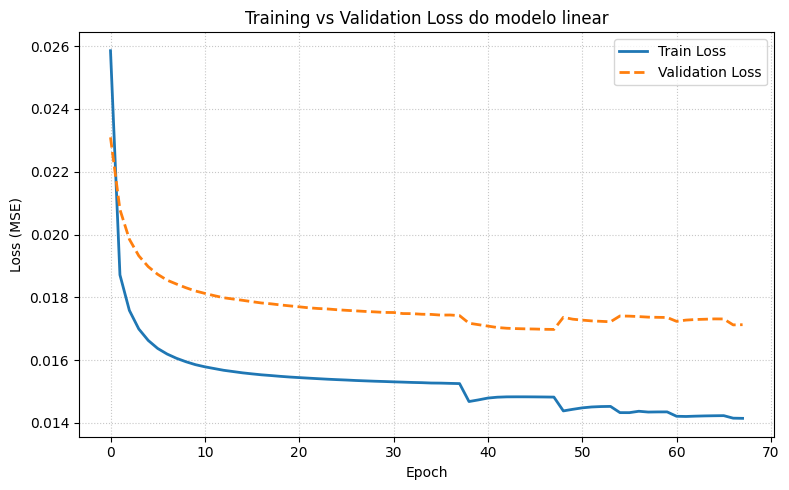

Histórico de treinamento do modelo: mlp...


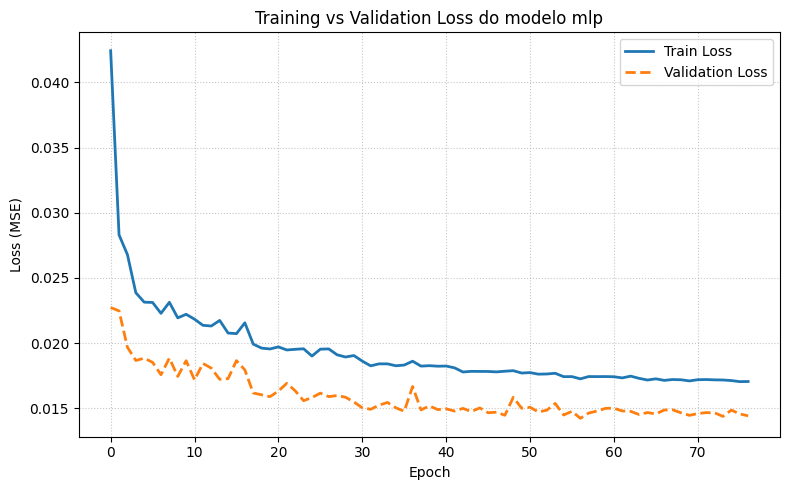

In [16]:
for model_name in histories.keys():
    print(f"Histórico de treinamento do modelo: {model_name}...")
    plot_training_history(histories[model_name], model_name)